<a href="https://colab.research.google.com/github/Kryptera-K/APD-WMA-Regression-Trend-Strategy/blob/main/APD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt
from sklearn.linear_model import LinearRegression

# -------------------------
# Download Data
# -------------------------

symbol = "APD"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("APD_clean.csv", index=False)
df

/tmp/ipython-input-1842688103.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,16.570841,17.012729,16.539277,16.823348,595847
2000-01-04,16.065828,16.444590,15.781757,16.413027,464938
2000-01-05,16.160522,16.349904,15.687070,16.065832,719189
2000-01-06,17.233671,17.896505,16.065822,16.413020,1485186
2000-01-07,18.433088,18.685595,17.012730,17.265237,1297092
...,...,...,...,...,...
2025-11-03,239.360001,242.070007,235.970001,241.910004,1472900
2025-11-04,240.770004,241.300003,237.110001,238.509995,1720000
2025-11-05,237.559998,241.479996,235.550003,240.770004,2160000


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

AO_CHANGE_SHIFT_1 = 5
AO_CHANGE_SHIFT_2 = 10
AO_LEVEL = 5
AO_LONG_PERIOD = 34
AO_SHORT_PERIOD = 5
EMA_PERIOD = 20
EMA_SHIFT = 5
LINREG_PERIOD = 14
LINREG_SHIFT = 5
WMA_PERIOD = 20

# -------------------------
# Indicator Functions
# -------------------------

def close_above_wma(df, period=WMA_PERIOD):
    df = calculate_wma(df, period)
    return df['Close'] > df['WMA']


def calculate_wma(df, period=WMA_PERIOD):
    """
    Calculate Weighted Moving Average (WMA) for the Close price
    and add it as a column to the DataFrame.
    """
    df = df.copy()
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df


def open_above_linreg_after_above(df, period=LINREG_PERIOD):
    df = df.copy()
    df['LinReg'] = calculate_linreg(df['Close'], period)
    return (df['Open'] > df['LinReg']) & (df['Open'].shift(1) > df['LinReg'].shift(1))


def calculate_linreg(series, period=LINREG_PERIOD):
    """
    Calculate Linear Regression value for each bar.
    """
    linreg_values = [np.nan] * len(series)
    for i in range(period - 1, len(series)):
        y = series[i - period + 1:i + 1].values.reshape(-1, 1)
        x = np.arange(period).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        linreg_values[i] = model.predict([[period - 1]])[0][0]
    return pd.Series(linreg_values, index=series.index)


def open_above_ema_after_below(df, period=EMA_PERIOD):
    df = calculate_ema(df, period)
    return (df['Open'] > df['EMA']) & (df['Open'].shift(1) < df['EMA'].shift(1))


def calculate_ema(df, period=EMA_PERIOD):
    """
    Calculate Exponential Moving Average (EMA) of the Close price.
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df


def ao_change_direction_upward(df, short_period=AO_SHORT_PERIOD, long_period=AO_LONG_PERIOD, shift1=AO_CHANGE_SHIFT_1, shift2=AO_CHANGE_SHIFT_2):
    df = calculate_ao(df, short_period, long_period)
    return (df['AO'].shift(shift1) > df['AO'].shift(shift2)) & (df['AO'] > df['AO'].shift(shift1))


def calculate_ao(df, short_period=AO_SHORT_PERIOD, long_period=AO_LONG_PERIOD):
    """
    Calculate Awesome Oscillator (AO)
    df : pandas DataFrame with ['High', 'Low']
    short_period : short SMA (default 5)
    long_period : long SMA (default 34)
    """
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(window=short_period, min_periods=1).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(window=long_period, min_periods=1).mean()
    df['AO'] = df["SMA_short"] - df["SMA_long"]
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Close_Above_WMA"] = close_above_wma(df)
df["LinReg_Open_Above_After_Above"] = open_above_linreg_after_above(df)

# -------------------------
# Exit conditions
# -------------------------

df["EMA_Open_Above_After_Below"] = open_above_ema_after_below(df)
df["AO_Change_Upward"] = ao_change_direction_upward(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Close_Above_WMA',
    'LinReg_Open_Above_After_Above',
]
exit_conditions = [
    'EMA_Open_Above_After_Below',
    'AO_Change_Upward',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                 2000-01-03 00:00:00
End                                   2025-11-07 00:00:00
Period                                 6503 days 00:00:00
Start Value                                      100000.0
End Value                                  2059432.296261
Total Return [%]                              1959.432296
Benchmark Return [%]                          1425.499011
Max Gross Exposure [%]                              100.0
Total Fees Paid                             118760.375525
Max Drawdown [%]                                36.435421
Max Drawdown Duration                   728 days 00:00:00
Total Trades                                           61
Total Closed Trades                                    60
Total Open Trades                                       1
Open Trade PnL                              -116734.77377
Win Rate [%]                                         65.0
Best Trade [%]                                  74.637522
Worst Trade [%

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-11-07 00:00:00
Period                         6503 days 00:00:00
Start Value                              100000.0
End Value                          1525499.011192
Total Return [%]                      1425.499011
Benchmark Return [%]                  1425.499011
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        58.870257
Max Drawdown Duration           776 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1425499.011192
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


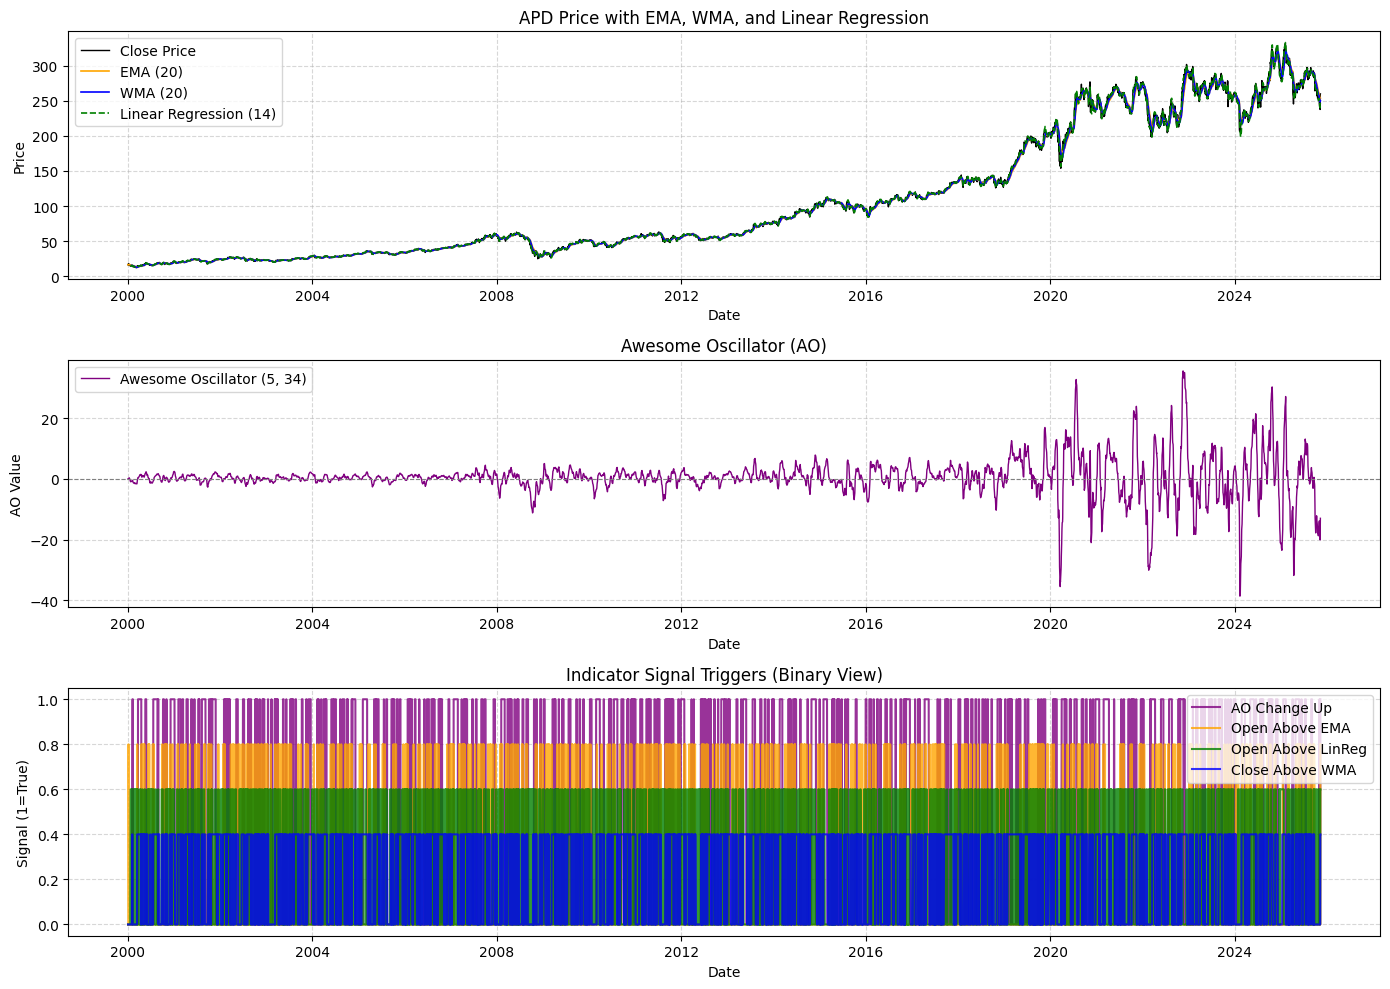

In [ ]:
import matplotlib.pyplot as plt

# ---------------------------------
# Calculate All Indicators
# ---------------------------------
df = calculate_wma(df)
df = calculate_ema(df)
df['LinReg'] = calculate_linreg(df['Close'])
df = calculate_ao(df)

# ---------------------------------
# Plot Setup
# ---------------------------------
plt.figure(figsize=(14, 10))

# --- Subplot 1: Price + EMA + WMA + Linear Regression ---
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='black', linewidth=1)
plt.plot(df['EMA'], label=f'EMA ({EMA_PERIOD})', color='orange', linewidth=1.2)
plt.plot(df['WMA'], label=f'WMA ({WMA_PERIOD})', color='blue', linewidth=1.2)
plt.plot(df['LinReg'], label=f'Linear Regression ({LINREG_PERIOD})', color='green', linestyle='--', linewidth=1.2)
plt.title(f"{symbol} Price with EMA, WMA, and Linear Regression")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# --- Subplot 2: Awesome Oscillator (AO) ---
plt.subplot(3, 1, 2)
plt.plot(df['AO'], label=f"Awesome Oscillator ({AO_SHORT_PERIOD}, {AO_LONG_PERIOD})", color='purple', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Awesome Oscillator (AO)")
plt.xlabel("Date")
plt.ylabel("AO Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# --- Subplot 3: Combined Indicator Signals ---
plt.subplot(3, 1, 3)
df['AO_Up'] = ao_change_direction_upward(df)
df['Open_Above_EMA'] = open_above_ema_after_below(df)
df['Open_Above_LinReg'] = open_above_linreg_after_above(df)
df['Close_Above_WMA'] = close_above_wma(df)

# Plot binary (True/False) signals
plt.plot(df.index, df['AO_Up'] * 1.0, label='AO Change Up', color='purple', alpha=0.8)
plt.plot(df.index, df['Open_Above_EMA'] * 0.8, label='Open Above EMA', color='orange', alpha=0.8)
plt.plot(df.index, df['Open_Above_LinReg'] * 0.6, label='Open Above LinReg', color='green', alpha=0.8)
plt.plot(df.index, df['Close_Above_WMA'] * 0.4, label='Close Above WMA', color='blue', alpha=0.8)
plt.title("Indicator Signal Triggers (Binary View)")
plt.xlabel("Date")
plt.ylabel("Signal (1=True)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
